In [239]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.optimize import brentq
import matplotlib.pylab as plt
import datetime as dt
from scipy import interpolate
from scipy.optimize import least_squares
from math import exp

Import data

In [2]:
data=pd.read_csv('IR_Data.csv',usecols=range(13),index_col=['Expiry','Tenor'],skiprows=[16,17,18])
data.head()

-200bps  -150bps  -100bps  -50bps  -25bps    ATM  +25bps  \
Expiry Tenor                                                             
1Y     1Y       91.57    62.03   44.130  31.224  26.182  22.50   20.96   
       2Y       83.27    61.24   46.570  35.807  31.712  28.72   27.12   
       3Y       73.92    56.87   44.770  35.745  32.317  29.78   28.29   
       5Y       55.19    44.64   36.510  30.242  27.851  26.07   24.98   
       10Y      41.18    35.04   30.207  26.619  25.351  24.47   23.98   

              +50bps  +100bps  +150bps  +200bps  
Expiry Tenor                                     
1Y     1Y      21.40    24.34   27.488   30.297  
       2Y      26.84    28.51   31.025   33.523  
       3Y      27.80    28.77   30.725   32.833  
       5Y      24.56    25.12   26.536   28.165  
       10Y     23.82    24.25   25.204   26.355

In [3]:
Swap=pd.read_excel('ATM.xlsx')
Swap

,1Y,2Y,3Y,5Y,10Y
1Y,0.032008,0.033260,0.034012,0.035259,0.038436
5Y,0.039302,0.040103,0.040105,0.041129,0.043676
10Y,0.042245,0.043174,0.044157,0.046313,0.053545


In [178]:
Expiry=np.array(['1Y','5Y','10Y'])
Tenor=np.array(['1Y','2Y','3Y','5Y','10Y'])
s=np.array([-200,-150,-100,-50,-25,0,25,50,100,150,200])
Notion=10_000

SABR Calibration

In [83]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

In [84]:
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], 0.9, x[1], x[2]))**2
    return err

In [171]:
SABR_Alpha=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
SABR_Rho=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
SABR_Nu=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
initialGuess_sabr=[0.1,-1,1]

In [172]:
for ex in Expiry:
    for te in Tenor:             #Set sigma,T,ATM,strikes
        sigma=data.loc[(ex,te), 'ATM']/100
        T=int(ex[:-1])
        ATM=Swap[te][ex] #ATM and K changes
        strikes=s*0.0001+ATM
        res=least_squares(lambda x: sabrcalibration(x,
                                           strikes,
                                           data.loc[ex,te].values/100,# [1,1] change to [ex,te]
                                           ATM,
                                           T),
                          initialGuess_sabr,
                          bounds=([0,-1,0],[np.inf,1,np.inf]))
        SABR_Alpha[te][ex]=res.x[0]
        SABR_Rho[te][ex]=res.x[1]
        SABR_Nu[te][ex]=res.x[2]

In [175]:
SABR_Alpha

,1Y,2Y,3Y,5Y,10Y
1Y,0.139070,0.184645,0.196850,0.177954,0.169842
5Y,0.166518,0.199530,0.210331,0.436740,0.520182
10Y,0.178446,0.184394,0.188978,0.285926,0.329694


In [176]:
SABR_Rho

,1Y,2Y,3Y,5Y,10Y
1Y,-0.633233,-0.525121,-0.482855,-0.413884,-0.254055
5Y,-0.585306,-0.547193,-0.549855,-0.780934,-0.838711
10Y,-0.549379,-0.508328,-0.492324,-0.666385,-0.705744


In [177]:
SABR_Nu

,1Y,2Y,3Y,5Y,10Y
1Y,2.049566,1.677478,1.438206,1.065924,0.794125
5Y,1.340616,1.062859,0.937577,1.098894,0.927944
10Y,1.012370,0.896365,0.831887,0.919166,0.827552


1Y 1Y


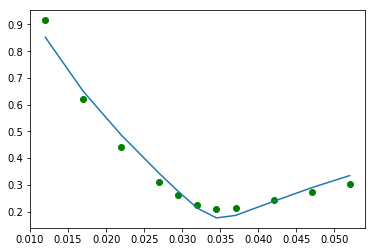

1Y 2Y


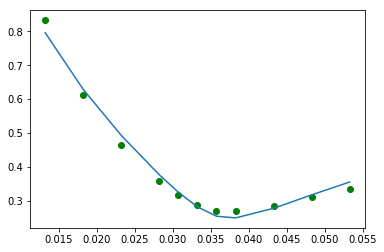

1Y 3Y


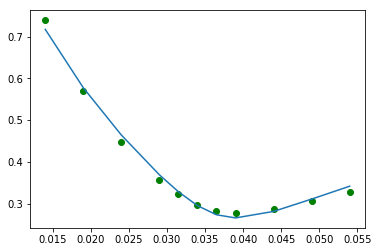

1Y 5Y


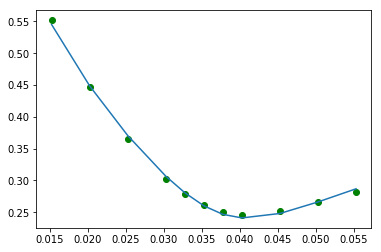

1Y 10Y


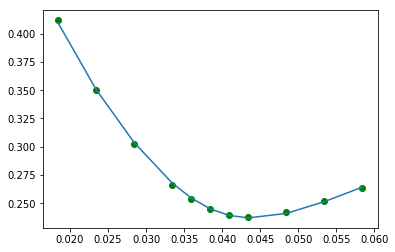

5Y 1Y


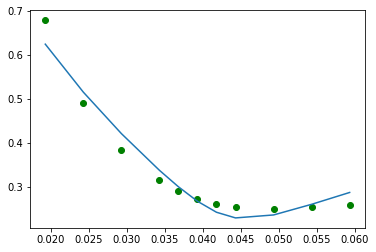

5Y 2Y


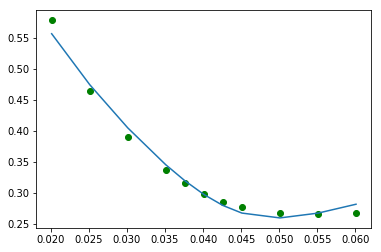

5Y 3Y


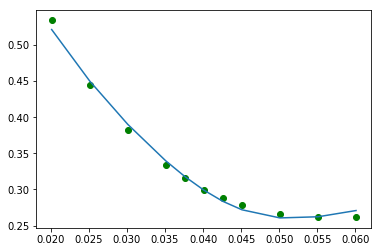

5Y 5Y


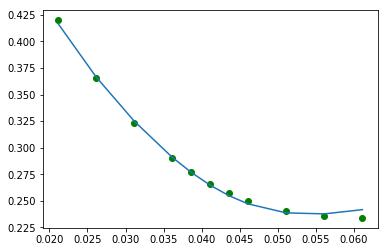

5Y 10Y


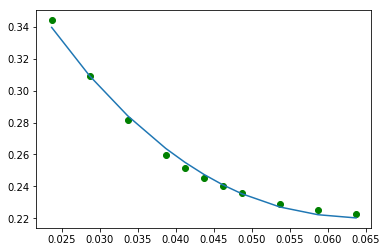

10Y 1Y


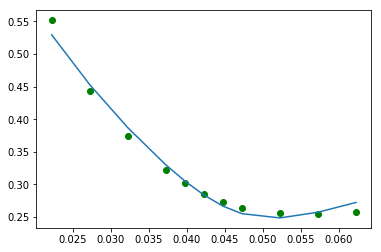

10Y 2Y


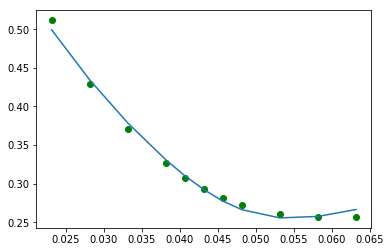

10Y 3Y


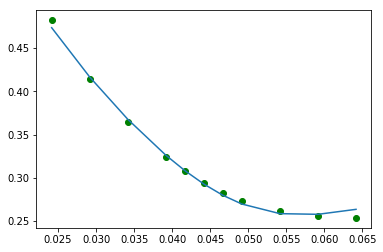

10Y 5Y


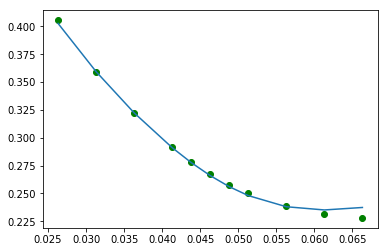

10Y 10Y


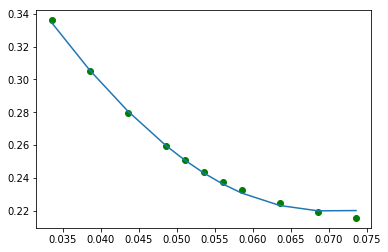

In [154]:
for ex in Expiry:
    for te,i in zip(Tenor,range(6)):
        print(ex,te)
        ATM=Swap[te][ex] #ATM and K changes
        strikes=s*0.0001+ATM
        T=int(ex[:-1])
        #plt.subplot(3,2,i+1)
        plt.plot(strikes,data.loc[ex,te].values/100,'go')
        plt.plot(strikes,[SABR(ATM,x,T,SABR_Alpha.loc[ex,te],0.9,SABR_Rho.loc[ex,te],SABR_Nu.loc[ex,te]) for x in strikes])
        plt.show()

Displaced-Diffusion Calibration

In [99]:
def DD_Model (F, K, sigma, T, Beta, TYPE):
    r=1
    if Beta==0:
        x_Star = (K-F)/(F*sigma*np.sqrt(T))
        Call=np.exp(-r*T)*((F-K)*ss.norm.cdf(-x_Star,0,1)+
                           F*sigma*np.sqrt(T)*ss.norm.pdf(-x_Star,0,1))
        Put=np.exp(-r*T)*((K-F)*ss.norm.cdf(x_Star,0,1)+
                             F*sigma*np.sqrt(T)*ss.norm.pdf(-x_Star,0,1))
    else:
        F=F/Beta
        K=K+((1-Beta))*F
        sigma=Beta*sigma
        d1 = (np.log(F/K)+(sigma**2)/2*T)/(sigma*np.sqrt(T))
        d2 = (np.log(F/K)-(sigma**2)/2*T)/(sigma*np.sqrt(T))
        Call = np.exp(-r*T)*(F*ss.norm.cdf(d1,0,1)-K*ss.norm.cdf(d2,0,1))
        Put = np.exp(-r*T)*(K*ss.norm.cdf(-d2,0,1)-F*ss.norm.cdf(-d1,0,1))
    if TYPE == 'Put':
        return Put
    else:
        return Call

In [282]:
def impliedVolatility(S, K, price, T, Beta):
    impliedVol = brentq(lambda x: price - 
                        DD_Model(S, K,  x, T, 1, 'Call'),
                        1e-6, 1)
    return impliedVol

In [247]:
def DD_Calibrate_Price(x,ATM,strikes,T,vols):
    err=0.0
    for i,vol in zip(range(len(strikes)), vols):
        price1 = Notion*DD_Model(ATM, strikes[i], vol, T, 1,'Call') #Beta=1 using Black76
        price2 = Notion*DD_Model(ATM, strikes[i], x[0], T, x[1], 'Call')
        err += (price1 - price2)**2
        #plt.scatter(strikes[i],price1,color='green')
    return err

In [272]:
initialGuess_DD=[0.5,0.2]
Cal_Beta=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
Cal_Sigma=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)

In [273]:
for ex in Expiry:
    for te in Tenor:             #Set sigma,T,ATM,strikes
        sigma=data.loc[(ex,te), 'ATM']/100
        T=int(ex[:-1])
        ATM=Swap[te][ex] #ATM and K changes
        strikes=s*0.0001+ATM
        res = least_squares(lambda x: DD_Calibrate_Price(x,
                                          ATM,
                                          strikes,
                                          T,                                          
                                          data.loc[ex,te].values/100),
                                          initialGuess_DD,
                                          bounds=([0,0],[np.inf,1]))
        Cal_Beta[te][ex]= res.x[1]
        Cal_Sigma[te][ex]=res.x[0] 

In [274]:
Cal_Beta

,1Y,2Y,3Y,5Y,10Y
1Y,0.091373,0.088585,0.113040,0.157930,0.218611
5Y,0.043586,0.076612,0.137187,0.242607,0.342015
10Y,0.349670,0.319363,0.317573,0.450592,0.294454


In [275]:
Cal_Sigma

,1Y,2Y,3Y,5Y,10Y
1Y,0.253213,0.315450,0.319594,0.272127,0.251564
5Y,0.301314,0.312628,0.308432,0.270126,0.247266
10Y,0.358868,0.361375,0.360982,0.308723,0.293560


In [293]:
imp=[impliedVolatility(ATM, x, p, T, 0.218611) for x,p in zip(strikes,price_DD)]
imp

[0.554502757133349,
 0.42809941908055305,
 0.341406211367684,
 0.28198630536672453,
 0.2609676872417633,
 0.2452843327845279,
 0.23448090151771211,
 0.22756517171148277,
 0.2220430362308178,
 0.22217478704742094,
 0.22447851062813087]

In [292]:
ATM=0.038436
sigma=0.2447
T=1
s=np.array([-200,-150,-100,-50,-25,0,25,50,100,150,200])
strikes=s*0.0001+ATM
price_DD=[DD_Model(ATM,x, data.loc['1Y','10Y'][i]/100, T,0.218611 ,'Call') for i,x in zip(range(len(strikes)),strikes)]
price_DD

[0.007585807249162973,
 0.005804041704016601,
 0.004105440429910859,
 0.0025778988891478442,
 0.0019266690592587728,
 0.0013801807242516733,
 0.0009514121305087151,
 0.0006358039772170604,
 0.0002701111522343565,
 0.00011232683366091826,
 4.6974903489505644e-05]

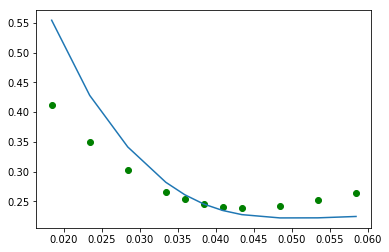

In [294]:
plt.plot(strikes,data.loc['1Y','10Y']/100,'go')
plt.plot(strikes,imp)

In [259]:
initialGuess_DD=[0.1,0.2]
ATM=0.038436
sigma=0.2447
T=1
s=np.array([-200,-150,-100,-50,-25,0,25,50,100,150,200])
strikes=s*0.0001+ATM
strikes

array([0.018436, 0.023436, 0.028436, 0.033436, 0.035936, 0.038436,
       0.040936, 0.043436, 0.048436, 0.053436, 0.058436])

In [260]:
res = least_squares(lambda x: DD_Calibrate_Price(x,
                                          ATM,
                                          strikes,
                                          T,                
                                          data.loc['1Y','10Y'].values/100),
                                          initialGuess_DD,
                                          bounds=([0,0],[np.inf,1]))

In [261]:
sigma=res.x[0]
beta=res.x[1]

In [262]:
sigma

0.25153422958290855

In [263]:
beta

0.2867933421869416

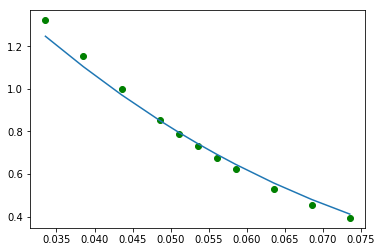

In [126]:
plt.plot(strikes,[Notion*DD_Model(ATM,x, data.loc['10Y','10Y'][i]/100, T, 1,'Call') for i,x in zip(range(len(strikes)),strikes)],'go')
plt.plot(strikes,[Notion*DD_Model(ATM, x, sigma, T,0.295704311, 'Call') for x in strikes])

In [116]:
data.loc['10Y','10Y'][1]

30.509

In [108]:
[Notion*DD_Model(ATM, x, sigma, T,0.295704311, 'Call') for x in strikes]

[1.2463110255095462,
 1.1030791149360326,
 0.9714239743417821,
 0.8513100156295426,
 0.7955185484801052,
 0.7425164261316074,
 0.6922512798864217,
 0.6446625639731133,
 0.5572371112420685,
 0.4796285544578012,
 0.41115499558742674]

PVBP Calculation

In [189]:
df=pd.read_csv('E:/Github/QF605_Fixed_Income_Sec/df.csv')
df.head()

,Tenor,OIS,ON,DF,L,Fwd_L,L_DF
0,0.5,0.00250,0.002497,0.998752,0.025,0.025000,0.987654
1,1.0,0.00300,0.002996,0.997009,0.028,0.031005,0.972577
2,1.5,NaN,0.003327,0.995022,NaN,0.031752,0.957378
3,2.0,0.00325,0.003495,0.993035,0.030,0.032264,0.942178
4,2.5,NaN,0.003524,0.991228,NaN,0.034219,0.926329


In [190]:
def PVBP(start,stop,coupon_period=0.5):
    value=0.0
    time=np.arange(start,stop+0.1,0.5)
    for i in time:
        value=value+df[df['Tenor']==i].DF.values
    return value*coupon_period

Q3: Pricing the following swaption

 payer 2y x 10y K = 1%; 2%; 3%; 4%; 5%; 6%; 7%; 8%

In [226]:
from scipy.interpolate import interp1d

In [228]:
def interpol(x1,y1,x2,y2,x):
    return y1+x*((y2-y1)/(x2-x1))

In [232]:
strike=np.arange(0.01,0.081,0.01)
T=2
ATM=interpol(1,26.355,5,22.250,2)
ATM

24.302500000000002

In [237]:
alpha=interpol(1,0.156374,5,0.181581,2)
rho=interpol(1,-0.193758,5,-0.070987,2)
nu=interpol(1,0.534328,5,0.205102,2)

In [240]:
def Black76Pay(F, K, T, sigma):
    d1 = (np.log(F/K)+(sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return (F*ss.norm.cdf(d1) - K*ss.norm.cdf(d2))

def Black76Rec(F, K, T, sigma):
    d1 = (np.log(F/K)+(sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return (K*ss.norm.cdf(-d2) - F*ss.norm.cdf(-d1))

In [245]:
value=[Notion*Black76Pay(ATM,x,T,SABR(ATM,x,T,alpha,0.9,rho,nu)) for x in strike]

In [246]:
value

[242925.0000000441,
 242825.0000001502,
 242725.00000031712,
 242625.00000054738,
 242525.00000084421,
 242425.00000121119,
 242325.00000165196,
 242225.00000217033]